# Compute and plot tide from OTPS2 (TPXO8) fortran code

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import datetime
import pandas
import urllib2, urllib
import pytides
import os
import subprocess
import copy
from netCDF4 import Dataset


In [3]:
#define point of measurement

In [4]:
point=1870

In [5]:
#start date
tstamp='20160601.000'
tin=datetime.datetime.strptime(tstamp,"%Y%m%d.%H%M%S")

In [6]:
#end day
estamp='20160630.000'
ed=datetime.datetime.strptime(estamp,"%Y%m%d.%H%M%S")

## READ tide gauge measurements

In [7]:
url='http://webcritech.jrc.ec.europa.eu/SeaLevelsDb/Home/ShowBuoyData?id={}&dateMin={}%2F{:02d}%2F{:02d}+{:02d}%3A{:02d}&dateMax={}%2F{:02d}%2F{:02d}+{:02d}%3A{:02d}&field=&options='\
                                 .format(point,tin.year,tin.month,tin.day,tin.hour,0,ed.year,ed.month,ed.day,ed.hour,0)


In [8]:
response=urllib2.urlopen(url)
ls=response.readlines()
lp=[elem.strip().split(',')  for elem in ls]

# get lat lon
c=[a.split(' ') for a in lp[1]][0]
if 'lat' in c[2]: 
           plat=c[2].split('=')[1]
           idt=6
else:
           c=[a.split(' ') for a in lp[2]][0]
           if 'lat' in c[2]: plat=c[2].split('=')[1]
           idt=7

if 'lon' in c[3]: plon=c[3].split('=')[1]



In [9]:
print plon, plat

12.427 45.418


In [10]:
rt=[]
vt=[]
mt=[]
ct=[]
for a,b,c,d in lp[idt:]:
    rt.append(datetime.datetime.strptime(a,'%d %b %Y %H:%M:%S'))
    mt.append(b) # height column
    vt.append(c) # tide column
    ct.append(d) # storm surge column


In [11]:
d=np.array([rt,mt,vt,ct]).T

In [12]:
dat1=pandas.DataFrame(d,columns=['time', 'Observation', 'jrc_tide', 'jrc_ss'])

In [13]:
dat1=dat1.set_index(['time'])

In [14]:
dat1['Observation']=pandas.to_numeric(dat1['Observation']) # convert string to floats
dat1['jrc_ss']=pandas.to_numeric(dat1['jrc_ss']) # convert string to floats
dat1['jrc_tide']=pandas.to_numeric(dat1['jrc_tide']) # convert string to floats

In [15]:
dat1[:1]

,Observation,jrc_tide,jrc_ss
time,,,
2016-06-01 00:01:00,-0.217,-0.206,-0.011


<IPython.core.display.Javascript object>


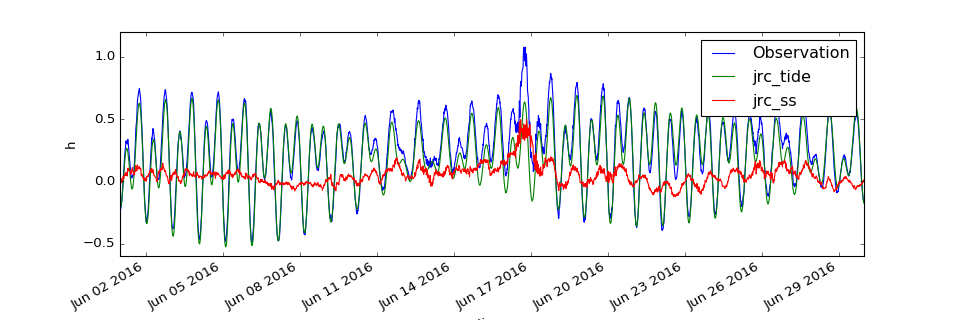

In [35]:
ax1=dat1.plot(figsize=(12,4))
ax1.set_ylabel('h')

## Compute constituents from measurements

In [47]:
demeaned=dat1['Observation'].values-dat1['Observation'].values.mean()

In [48]:
tide=pytides.tide.Tide.decompose(demeaned, dat1['Observation'].index)

In [49]:
constituent = [c.name for c in tide.model['constituent']]

In [50]:
df=pandas.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)

In [53]:
df.sort_values(by='amplitude', ascending=False).head(10) # 10 highest amplitudes

,amplitude,phase
S1,55.758923,14.297858
K1,30.460944,185.796578
P1,29.224589,200.041431
R2,17.389742,265.824626
K2,12.231772,269.260795
T2,7.008785,306.371419
L2,6.448387,21.576339
lambda2,5.471614,106.868389
nu2,2.412166,135.986447
N2,2.281998,213.334093


### validating tide analysis

In [54]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [55]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [56]:
times=pytides.tide.Tide._times(dates[0], hours)

In [57]:
validation = pandas.Series(tide.at(times) + dat1['jrc_tide'].values.mean(), index=dates)

<IPython.core.display.Javascript object>


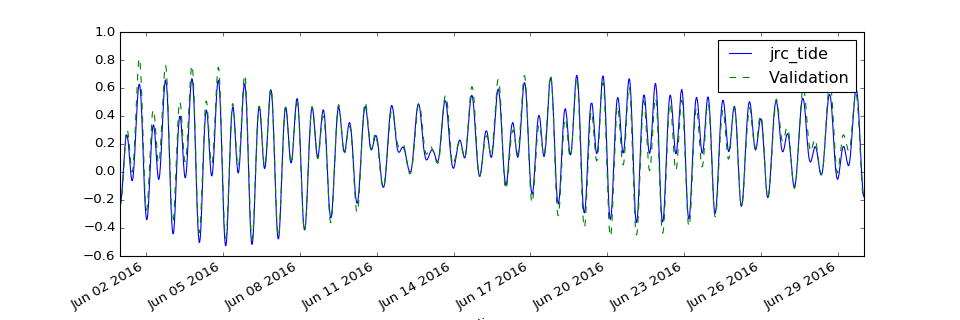

In [58]:
ax = dat1['jrc_tide'].plot(figsize=(12,4))
ax = validation.plot(ax=ax, color='green', linestyle='--', label='Validation')
leg=ax.legend(loc='best')

In [59]:
print('Form number {}, the tide is {}.'.format(tide.form_number()[0], tide.classify()))

Form number 11.0421042396, the tide is diurnal.


### Predicting tide 

In [106]:
pdates=pandas.date_range(start='2016-06-30',end='2016-07-08',freq='6T')

In [107]:
phours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(pdates.to_pydatetime())]])

In [108]:
ptimes=pytides.tide.Tide._times(pdates[0], phours)

In [109]:
ptimes

array([Timestamp('2016-06-30 00:00:00', offset='6T'),
       Timestamp('2016-06-30 00:06:00', offset='6T'),
       Timestamp('2016-06-30 00:12:00', offset='6T'), ...,
       Timestamp('2016-07-07 23:48:00', offset='6T'),
       Timestamp('2016-07-07 23:54:00', offset='6T'),
       Timestamp('2016-07-08 00:00:00', offset='6T')], dtype=object)

In [110]:
prediction = pandas.Series(tide.at(ptimes) + dat1['Observation'].values.mean(), index=pdates)

<IPython.core.display.Javascript object>


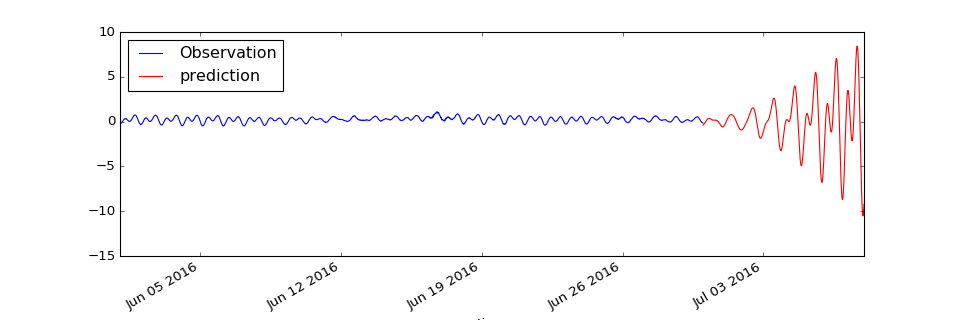

In [115]:
ax = dat1['Observation'].plot(figsize=(12,4))
ax = prediction.plot(ax=ax, color='red', label='prediction')
leg=ax.legend(loc='best')

### Setup the fortan files

In [74]:
path='../TIDES/OTPS2/'

In [75]:
# location
#plon=-5.72
#plat=36.

In [76]:
#dt
delta=datetime.timedelta(hours=1)

In [77]:
with open(path+'lat_lon_time1','w') as f:
    while tin <= ed: 
     f.write('{}  {}  {}  {}  {}  {}  {}  {}\n'.format(plat,plon,tin.year,tin.month,tin.day,tin.hour,tin.minute, tin.second))
     tin += delta

## Evaluate Constituents (TPX08)

In [78]:
ex=subprocess.Popen('./extract_HC < setup.inp', cwd=path, shell=True, stdout=subprocess.PIPE)
stdout=ex.communicate()[0]
print stdout

 DATA/Model_atlas_v1
 Lat/Lon file:lat_lon_time1
 Extract OCEAN tide HC
 Model type: atlas (combined of several models)
 Models in atlas:          30
 Lat limits:     -90.0833359       90.0833359    
 Lon limits:      8.33384171E-02   360.083344    
 Output elevations (m)
 Constituents: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Constituents to include: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Loading local solution grid Med2011             
 Loading local solution elevations Med2011             
 Results are in sample1.out



In [79]:
out=pandas.read_csv(path+'sample1.out',skiprows=[0,1,3],delim_whitespace=True, skipinitialspace=True)#, index_col=['mm.dd.yyyy','hh:mm:ss'] )

In [80]:
out

,Lat,Lon,m2_amp,m2_ph,s2_amp,s2_ph,n2_amp,n2_ph,k2_amp,k2_ph,...,m4_amp,m4_ph,ms4_amp,ms4_ph,mn4_amp,mn4_ph,mm_amp,mm_ph,mf_amp,mf_ph
0,45.418,12.427,0.236,-98.8,0.152,-96.2,0.032,-93.7,0.036,-92.2,...,0.001,107.4,0.001,-149.5,0.001,166.2,0.004,-165.6,0.007,-172.9


In [81]:
cst=out.drop(['Lat','Lon'], axis=1).T

In [82]:
idx=[ c.split('_')[0] for c in cst.index[::2]]

In [83]:
for i in range(np.size(idx)):
    if idx[i] != 'mf' : 
        idx[i]=idx[i][:].upper()
    else:
        idx[i]=idx[i][:1].upper()+idx[i][1:]

In [84]:
pcst=pandas.DataFrame(cst.values.reshape((-1,2)), columns=['amplitude','phase'], index=idx)

In [85]:
#compare the 2 solutions
com=pandas.concat([pcst,df], axis=1).dropna()

In [86]:
com

,amplitude,phase,amplitude,phase
K1,0.145,60.6,30.460944,185.796578
K2,0.036,-92.2,12.231772,269.260795
M2,0.236,-98.8,0.674410,16.891255
M4,0.001,107.4,0.002983,285.684627
MN4,0.001,166.2,0.002090,206.776920
MS4,0.001,-149.5,0.002799,239.942394
Mf,0.007,-172.9,0.090310,45.095158
N2,0.032,-93.7,2.281998,213.334093
O1,0.033,61.9,0.311246,325.393463
P1,0.044,62.2,29.224589,200.041431


## Predict tide (TPX08)

In [87]:
tp=subprocess.Popen('./predict_tide < setup.inp', cwd=path, shell=True, stdout=subprocess.PIPE )
stdout=tp.communicate()[0]
print stdout

 DATA/Model_atlas_v1
 Lat/Lon/Time file:lat_lon_time1
 Predict OCEAN tide
 Interpolate minor constituents
 Model type: atlas (combined of several models)
 Models in atlas:          30
 Lat limits:     -90.0833359       90.0833359    
 Lon limits:      8.33384171E-02   360.083344    
 Predict elevations (m)
 Constituents: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Constituents to include: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Loading local solution grid Med2011
 Loading local solution elevations Med2011             
 Results are in sample1.out



In [88]:
data=pandas.read_csv(path+'sample1.out',skiprows=[0,1,2,3,6],delim_whitespace=True, skipinitialspace=True)#, index_col=['mm.dd.yyyy','hh:mm:ss'] )

In [89]:
#print first row for verification
data[:1]

,Lat,Lon,mm.dd.yyyy,hh:mm:ss,z(m),Depth(m)
0,45.418,12.427,06.01.2016,00:00:00,-0.342,5


In [90]:
#merge columns for date
data['time']=data['mm.dd.yyyy'].astype(str).str.cat(data['hh:mm:ss'].astype(str), sep=' ')

In [91]:
#print first row for verification
data[:1]

,Lat,Lon,mm.dd.yyyy,hh:mm:ss,z(m),Depth(m),time
0,45.418,12.427,06.01.2016,00:00:00,-0.342,5,06.01.2016 00:00:00


In [92]:
#Delete unwanted columns
dat = data.drop(['Lat','Lon','Depth(m)','mm.dd.yyyy', 'hh:mm:ss'], axis=1)

In [93]:
dat['time']=pandas.to_datetime(dat['time'])

In [94]:
#set time as index
dat=dat.set_index(['time'])

In [95]:
#h=pandas.Series(dat['z(m)'])

In [96]:
ax=dat.plot(figsize=(12,4))
ax.set_ylabel('h')


<IPython.core.display.Javascript object>

In [97]:
#put together
#add2=dat1.join(dat,how='inner')

In [98]:
#add2.plot(x=add2.index,y=['elev','z(m)'], figsize=(12,4))

In [100]:
# Add the mean value of the measurement
dat['z(m)']=dat['z(m)']+dat1['Observation'].values.mean()

<IPython.core.display.Javascript object>


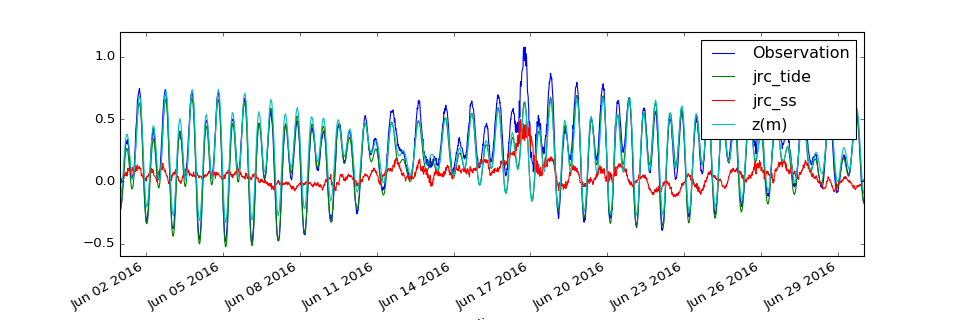

In [101]:
# PLOT TOGETHER
ax3=dat1.plot(figsize=(12,4))
dat.plot(ax=ax3)

In [ ]:
# set a tide object to validate
to=copy.deepcopy(tide)

In [ ]:
to.model['amplitude']

In [ ]:
k=0
for c,a,p in to.model:
    if c.name in pcst.index:
        to.model['amplitude'][k] = pcst['amplitude'][c.name]
        to.model['phase'][k] = pcst['phase'][c.name]
    else:
        to.model['amplitude'][k]=0.
        to.model['phase'][k]=0.
    k +=1    

In [ ]:
to.model['amplitude']

#### computing tide

In [ ]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [ ]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [ ]:
times=pytides.tide.Tide._times(dates[0], hours)

In [ ]:
tpx08 = pandas.Series(to.at(times) + dat1['elev'].values.mean(), index=dates)

In [ ]:
ax = dat1.plot(figsize=(12,8), label='Observed data')
tpx08.plot(ax=ax, color='green', linestyle='--', label='pytides from constituents')
#validation.plot(ax=ax, color='k', linestyle='--', label='pytides from Observed Data')
dat.plot(ax=ax, color='orange', linestyle='-', marker='.', label='tpx08 prediction')
leg=ax.legend(loc='best')

## Get the values from DELTARES med.nc

In [ ]:
dmed=Dataset(path+'../med.nc')

In [ ]:
dmed.variables.keys()

In [ ]:
lat=dmed['lat'][:]
lon=dmed['lon'][:]

In [ ]:
print lon.min(), lon.max()
print lat.min(), lat.max()

In [ ]:
i=np.abs(lon-np.float(plon)).argmin()
j=np.abs(lat-np.float(plat)).argmin()

In [ ]:
print plat, lat[j]
print plon, lon[i]

In [ ]:
tidal_c=dmed['tidal_constituents'][:]

In [ ]:
tidal_c=[''.join(k).upper().strip() for k in tidal_c]
tidal_c    

In [ ]:
print dmed['tidal_amplitude_h'].shape

In [ ]:
amp=dmed['tidal_amplitude_h'][i,j,:]
amp

In [ ]:
ph=dmed['tidal_phase_h'][i,j,:]
ph

In [ ]:
dd=np.array([amp,ph]).T
dd

In [ ]:
df=pandas.DataFrame(dd, columns=['amplitude','phase'], index=tidal_c)
df

In [ ]:
# set a tide object to validate
tomed=copy.deepcopy(tide)

In [ ]:
k=0
for c,a,p in tomed.model:
    if c.name in df.index:
        tomed.model['amplitude'][k] = df['amplitude'][c.name]
        tomed.model['phase'][k] = df['phase'][c.name]
    else:
        tomed.model['amplitude'][k]=0.
        tomed.model['phase'][k]=0.
    k +=1    

In [ ]:
tomed.model['amplitude']

In [ ]:
tomed.model['phase']

In [ ]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [ ]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [ ]:
times=pytides.tide.Tide._times(dates[0], hours)

In [ ]:
med_deltares = pandas.Series(tomed.at(times) + dat1['elev'].values.mean(), index=dates)

In [ ]:
ax = dat1.plot(figsize=(12,8), label='Observed data')
med_deltares.plot(ax=ax, color='green', linestyle='--', label='pytides from deltares med')
leg=ax.legend(loc='best')

## Get the values from DELTARES tpxo72.nc

In [ ]:
tpx7=Dataset(path+'../tpxo72.nc')

In [ ]:
tpx7.variables.keys()

In [ ]:
lat7=tpx7['lat'][:]
lon7=tpx7['lon'][:]

In [ ]:
print lon7.min(), lon7.max()
print lat7.min(), lat7.max()

In [ ]:
i7=np.abs(lon7-np.float(plon)).argmin()
j7=np.abs(lat7-np.float(plat)).argmin()

In [ ]:
print plat, lat7[j7]
print plon, lon7[i7]

In [ ]:
tidal_c7=tpx7['tidal_constituents'][:]

In [ ]:
tidal_c7=[''.join(k).upper().strip() for k in tidal_c7]
tidal_c7    

In [ ]:
tidal_c7[-5]='Mf' # make compatible with pytides

In [ ]:
print tpx7['tidal_amplitude_h'].shape

In [ ]:
amp7=tpx7['tidal_amplitude_h'][i7,j7,:]
amp7

In [ ]:
ph7=tpx7['tidal_phase_h'][i7,j7,:]
ph7

In [ ]:
dd7=np.array([amp7,ph7]).T
dd7

In [ ]:
df7=pandas.DataFrame(dd7, columns=['amplitude','phase'], index=tidal_c7)
df7

In [ ]:
# set a tide object to validate
to7=copy.deepcopy(tide)

In [ ]:
k=0
for c,a,p in to7.model:
    if c.name in df7.index:
        to7.model['amplitude'][k] = df7['amplitude'][c.name]
        to7.model['phase'][k] = df7['phase'][c.name]
    else:
        to7.model['amplitude'][k]=0.
        to7.model['phase'][k]=0.
    k +=1    

In [ ]:
to7.model['amplitude']

In [ ]:
to7.model['phase']

In [ ]:
dates=pandas.date_range(start='2016-06-01',end='2016-06-30',freq='6T')

In [ ]:
hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

In [ ]:
times=pytides.tide.Tide._times(dates[0], hours)

In [ ]:
med7 = pandas.Series(to7.at(times) + dat1['elev'].values.mean(), index=dates)

In [ ]:
ax = dat1.plot(figsize=(12,8), label='Observed data')
med7.plot(ax=ax, color='green', linestyle='--', label='pytides from deltares tpx7.2')
med_deltares.plot(ax=ax, color='red', linestyle='--', label='pytides from deltares med')
dat.plot(ax=ax, color='orange', linestyle='-', marker='.', label='pytides from tpx8')
leg=ax.legend(loc='best')